In [2]:
# -------- #
# PACKAGES #
# -------- #
import time
import pickle
import torch
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from torch.utils.data import Dataset, DataLoader

# ---------------- #
# GENERAL SETTINGS #
# ---------------- #
torch.manual_seed(42)
sns.set_theme(style="white")

# ---------------- #
# GLOBAL VARIABLES #
# ---------------- #
from config import (
    # Drug features.
    PATH_TO_SAVED_DRUG_FEATURES,
    DRUG_FPS_FINAL_FILE_NAME,
    # Cell line features.
    PATH_TO_SAVED_CL_FEATURES,
    GENE_EXPR_FINAL_FILE_NAME,
    CNV_GISTIC_FINAL_FILE_NAME,
    CNV_PICNIC_FINAL_FILE_NAME    
)

---

# Building a Baseline Model

The objective of this notebook is to research on how to build a baseline model to test the future GNN approach against. It should be a Deep Learning model for Drug Response Prediction with the following general structure.

<p align="center">
    <img src="imgs/GeneralDLModelForDRP.png" alt="drawing" width="400"/>
</p>

In [562]:
PATH_TO_SAVE_MODELS_TO = '../../datasets/models/'

---

## Cell Features

In [3]:
# --------------- #
# GENE EXPRESSION #
# --------------- #
start = time.time()
gene_expr = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{GENE_EXPR_FINAL_FILE_NAME}')
print(f"Shape: {gene_expr.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(gene_expr.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(gene_expr.columns[14:])}")
gene_expr.head(3)

Shape: (446521, 922) took 4.11994 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 908


,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,0.984816,2366,3.140923,2.0,1342,404197,GDSC1,0.508635,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,0.985693,2368,3.968757,2.0,610,797378,GDSC1,1.284229,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [4]:
gene_expr[gene_expr.CELL_LINE_NAME=='MC-CAR'].head(5)

,DRUG_ID,CELL_LINE_NAME,AUC,CELL_ID,LN_IC50,CONC,MASTER_CELL_ID,INTENSITY,DATASET,Z_SCORE,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,0.982114,3137,2.395685,2.0,49,544404,GDSC1,-0.189576,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
4563,3,MC-CAR,0.980891,3137,-0.658244,0.1,49,558232,GDSC1,0.806489,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
8613,5,MC-CAR,0.903979,3137,2.161095,8.0,49,333014,GDSC1,-0.206663,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
12843,6,MC-CAR,0.986077,3137,2.613997,2.0,49,635581,GDSC1,-0.137000,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
17478,9,MC-CAR,0.937027,3137,0.530615,1.0,49,423727,GDSC1,0.410332,...,8.355826,8.95168,7.20559,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366


- Note that for the same `CELL_LINE_NAME` the gene expression value is the same.
- It only differs for a different `DRUG_ID` for that specific cell line.
- The `LN_IC50` is therefore different for each different cell-line - drug tuple.

Thus, 
- each row has different ic50 value
- not each row has a different value per gene column

In [5]:
# --------------------- #
# COPY NUMBER VARIATION #
# --------------------- #
# Copy number variation gistic final dataset.
start = time.time()
final_cnv_gistic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_GISTIC_FINAL_FILE_NAME}')
print(f"CNV Gistic: {final_cnv_gistic.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(final_cnv_gistic.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(final_cnv_gistic.columns[14:])}")

# Copy number variation picnic final dataset.
start = time.time()
final_cnv_picnic = pd.read_pickle(f'{PATH_TO_SAVED_CL_FEATURES}{CNV_PICNIC_FINAL_FILE_NAME}')
print(f"CNV Picnic: {final_cnv_picnic.shape} took {time.time()-start:.5f} seconds.")
print(f"  Number of unique cell-lines : {len(np.unique(final_cnv_picnic.CELL_LINE_NAME.values))}")
print(f"  Number of gene columns      : {len(final_cnv_picnic.columns[14:])}")
final_cnv_picnic.head(3)

CNV Gistic: (446521, 952) took 129.31703 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 938
CNV Picnic: (446521, 980) took 143.21013 seconds.
  Number of unique cell-lines : 988
  Number of gene columns      : 966


,MASTER_CELL_ID,CELL_ID,CONC,CELL_LINE_NAME,RMSE,AUC,INTENSITY,COSMIC_ID,DRUG_NAME,POSITION,...,ZMIZ1,ZMYM2,ZNF131,ZNF274,ZNF318,ZNF395,ZNF451,ZNF586,ZNF589,ZW10
0,49,3137,2.0,MC-CAR,0.022521,0.982114,544404,683665,Erlotinib,14,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
9,1342,2366,2.0,ES3,0.031840,0.984816,404197,684055,Erlotinib,14,...,1.0,1.0,2.0,2.0,2.0,3.0,2.0,2.0,3.0,2.0
27,610,2368,2.0,ES5,0.026052,0.985693,797378,684057,Erlotinib,14,...,2.0,3.0,3.0,3.0,4.0,6.0,4.0,3.0,4.0,3.0


- All dataframes have the same number of unique cell-lines.

In [6]:
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]
# Check if all non-gene symbol columns are the same.
assert len(non_gene_cols) == len(list(set(gene_expr.columns[:14]).intersection(set(final_cnv_gistic.columns[:14])).intersection(set(final_cnv_picnic.columns[:14]))))
assert set(gene_expr.columns[:14]) == set(final_cnv_gistic.columns[:14]) == set(final_cnv_picnic.columns[:14])

In [7]:
# Only select the gene symbol columns.
gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_cols__cnvgistic = final_cnv_gistic.loc[:, ~final_cnv_gistic.columns.isin(non_gene_cols)]
gene_cols__cnvpicnic = final_cnv_picnic.loc[:, ~final_cnv_picnic.columns.isin(non_gene_cols)]

In [8]:
# Gene symbols which are in all cell feature dataframes.
in_all = set(gene_cols__geneexpr.columns).intersection(\
         set(gene_cols__cnvgistic.columns)).intersection(\
         set(gene_cols__cnvpicnic.columns))
len_in_all = len(in_all)
print(f"""The number of gene columns which are existent in all dataframes is:\n{len_in_all}
This corresponds to
    {100*len_in_all/len(gene_cols__geneexpr.columns):2.2f} % of the gene expression gene columns.
    {100*len_in_all/len(gene_cols__cnvgistic.columns):2.2f} % of the cnv gistic      gene columns.
    {100*len_in_all/len(gene_cols__cnvpicnic.columns):2.2f} % of the cnv picnic      gene columns.""")             

The number of gene columns which are existent in all dataframes is:
870
This corresponds to
    95.81 % of the gene expression gene columns.
    92.75 % of the cnv gistic      gene columns.
    90.06 % of the cnv picnic      gene columns.


In [9]:
# Only select the gene columns which are in all dataframes. 
keep = ['CELL_LINE_NAME']
gene_expr_v2 = gene_expr[keep + list(in_all)]
cnv_gistic_v2 = final_cnv_gistic[keep + list(in_all)]
cnv_picnic_v2 = final_cnv_picnic[keep + list(in_all)]

print(f"""After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : {gene_expr_v2.shape}
    cnv gistic : {cnv_gistic_v2.shape}
    cnv picnic : {cnv_picnic_v2.shape}
""")
gene_expr_v2.head(3)

After selecting only the genes which are existent in all dataset the shapes are:
    gene expr  : (446521, 871)
    cnv gistic : (446521, 871)
    cnv picnic : (446521, 871)



,CELL_LINE_NAME,DAG1,CREG1,DNAJB1,PIK3C3,DLD,FBXL12,PAK6,NR2F6,APPBP2,...,C5,MPC2,CDC45,VPS28,GSTZ1,GDPD5,WDTC1,HMGCS1,PIN1,IDE
0,MC-CAR,4.081657,5.677272,6.180353,8.571591,10.334329,7.505240,3.069739,3.299431,6.125682,...,4.049017,9.057813,6.903852,8.363889,6.544324,3.830996,3.461435,7.187368,5.498214,7.723952
9,ES3,4.196450,7.051789,5.371774,8.330160,10.126326,6.338445,3.057186,3.981936,7.588107,...,5.373765,8.097682,5.208866,9.776040,6.275633,3.354604,3.366880,5.926742,5.984129,6.754155
27,ES5,4.371250,7.685916,6.476477,8.960452,10.018826,6.803424,3.761746,4.115502,6.899499,...,3.907119,8.554381,6.212660,9.897498,4.892096,3.784822,3.413021,7.650277,5.590448,6.349301


In [10]:
# Only select one row per unique cell-line, since the feature values are the same anyways.
gene_expr_v3 = gene_expr_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_gistic_v3 = cnv_gistic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
cnv_picnic_v3 = cnv_picnic_v2.drop_duplicates()  # same as .groupby('CELL_LINE_NAME').first()
print(f"""Shapes after removing duplicate cell-lines:
    gene expr  : {gene_expr_v3.shape}
    cnv gistic : {cnv_gistic_v3.shape}
    cnv picnic : {cnv_picnic_v3.shape}
""")

Shapes after removing duplicate cell-lines:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)



In [11]:
# Sort dataframes by cell-line column.
gene_expr_v4 = gene_expr_v3.sort_values(['CELL_LINE_NAME'])
cnv_gistic_v4 = cnv_gistic_v3.sort_values(['CELL_LINE_NAME'])
cnv_picnic_v4 = cnv_picnic_v3.sort_values(['CELL_LINE_NAME'])

# Check element-wise if the cell-line columns are exactly the same.
assert (gene_expr_v4.CELL_LINE_NAME == cnv_gistic_v4.CELL_LINE_NAME).all()
assert (cnv_gistic_v4.CELL_LINE_NAME == cnv_picnic_v4.CELL_LINE_NAME).all()

print(f"""Shapes after by the cell-line column:
    gene expr  : {gene_expr_v4.shape}
    cnv gistic : {cnv_gistic_v4.shape}
    cnv picnic : {cnv_picnic_v4.shape}
""")
gene_expr_v4.head(3)

Shapes after by the cell-line column:
    gene expr  : (988, 871)
    cnv gistic : (988, 871)
    cnv picnic : (988, 871)



,CELL_LINE_NAME,DAG1,CREG1,DNAJB1,PIK3C3,DLD,FBXL12,PAK6,NR2F6,APPBP2,...,C5,MPC2,CDC45,VPS28,GSTZ1,GDPD5,WDTC1,HMGCS1,PIN1,IDE
190089,201T,5.176508,10.016432,6.453210,6.949563,11.018893,6.608961,3.270474,4.646564,6.793711,...,8.544732,10.659183,3.837447,8.536009,4.919427,3.377033,3.310140,8.576079,4.915888,7.577092
188514,22RV1,4.531809,7.914579,6.339245,7.834045,9.595623,7.023759,4.668833,3.993249,6.527064,...,8.655075,11.065614,6.734605,8.691275,6.692639,3.462619,3.187604,8.353595,6.067534,6.678702
188316,23132-87,4.742977,9.960903,7.649852,8.561532,10.189863,6.714387,3.349600,5.553722,6.268291,...,5.834866,9.766390,4.359462,10.425257,6.662953,4.402000,3.390102,6.734930,5.695096,7.719844


Now all datasets have a feature value for the specific gene (column) and cell-line (row).

$$
\left [ \begin{array}{ccccccc} 
           & g_1         & g_2         & \cdots & g_i         & \cdots & g_n \\
    c_1    & \begin{bmatrix} v_{ge}^{11} \\ v_{cg}^{11} \\ v_{cp}^{11} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{12} \\ v_{cg}^{12} \\ v_{cp}^{12} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1i} \\ v_{cg}^{1i} \\ v_{cp}^{1i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1n} \\ v_{cg}^{1n} \\ v_{cp}^{1n} \end{bmatrix} 
           \\ 
    c_2    & \begin{bmatrix} v_{ge}^{21} \\ v_{cg}^{21} \\ v_{cp}^{21} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{22} \\ v_{cg}^{22} \\ v_{cp}^{22} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2i} \\ v_{cg}^{2i} \\ v_{cp}^{2i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2n} \\ v_{cg}^{2n} \\ v_{cp}^{2n} \end{bmatrix} 
           \\ 
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_j    & \begin{bmatrix} v_{ge}^{j1} \\ v_{cg}^{j1} \\ v_{cp}^{j1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{j2} \\ v_{cg}^{j2} \\ v_{cp}^{j2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{ji} \\ v_{cg}^{ji} \\ v_{cp}^{ji} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{jn} \\ v_{cg}^{jn} \\ v_{cp}^{jn} \end{bmatrix} 
           \\   
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_m    & \begin{bmatrix} v_{ge}^{m1} \\ v_{cg}^{m1} \\ v_{cp}^{m1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{m2} \\ v_{cg}^{m2} \\ v_{cp}^{m2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mi} \\ v_{cg}^{mi} \\ v_{cp}^{mi} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mn} \\ v_{cg}^{mn} \\ v_{cp}^{mn} \end{bmatrix} 
           \\            
\end{array} \right ]
$$
where 
$$
       c_j := \text{cell line} \; j \\
       g_i := \text{gene} \; i \\
       v_{ge}^{ji} := \text{Gene Expression value of gene} \; i \; \text{ in cell line} \; j \\
       v_{cg}^{ji} := \text{Gistic Copy Number value of gene} \; i \; \text{ in cell line} \; j \\
       v_{cp}^{ji} := \text{Picnic Copy Number value of gene} \; i \; \text{ in cell line} \; j \\
       
$$

- One example is for one cell-line.
- we have the same number of features and genes per cell-line.
- in total we have 446,521 examples we can use to train the model
- out of which 988 are unique cell-lines.

In [12]:
"""
1st dim = features
2nd dim = cell-lines
3rd dim = genes
"""
gene_tensor = torch.tensor([
    gene_expr_v4.loc[:, gene_expr_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64), 
    cnv_gistic_v4.loc[:, cnv_gistic_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64), 
    cnv_picnic_v4.loc[:, cnv_picnic_v4.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64)
])
print(f"Gene tensor shape: {gene_tensor.shape}")
gene_tensor

Gene tensor shape: torch.Size([3, 988, 870])


/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_38101/4172850249.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756028548/work/torch/csrc/utils/tensor_new.cpp:210.)
  gene_tensor = torch.tensor([


tensor([[[ 5.1765, 10.0164,  6.4532,  ...,  8.5761,  4.9159,  7.5771],
         [ 4.5318,  7.9146,  6.3392,  ...,  8.3536,  6.0675,  6.6787],
         [ 4.7430,  9.9609,  7.6499,  ...,  6.7349,  5.6951,  7.7198],
         ...,
         [ 4.3330, 10.4536,  6.2461,  ...,  9.2214,  4.8239,  8.1262],
         [ 5.1371,  7.5222,  6.8732,  ...,  8.7492,  6.0484,  7.3900],
         [ 4.8598,  7.7326,  6.5240,  ...,  6.5641,  5.1952,  6.8858]],

        [[ 1.0000,  1.0000, -1.0000,  ...,  1.0000, -1.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000, -1.0000,  ...,  0.0000, -1.0000,  0.0000],
         ...,
         [ 0.0000,  1.0000, -1.0000,  ...,  0.0000, -1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000, -1.0000],
         [ 1.0000,  0.0000, -1.0000,  ...,  2.0000, -1.0000,  0.0000]],

        [[ 3.0000,  5.0000,  3.0000,  ...,  5.0000,  3.0000,  3.0000],
         [ 2.0000,  3.0000,  2.0000,  ...,  2

__Note__:
- 1st Dimension: (the Features)
  - `gene_tensor[0]`: all cell-line genes values for the Gene Expression feature.
  - `gene_tensor[1]`: all cell-line genes values for the CNV Gistic feature.
  - `gene_tensor[2]`: all cell-line genes values for the CNV Picnic feature. 
- 2nd Dimension: (the cell-lines)
  - `gene_tensor[0][0]`: all Gene Expresion values for all genes for the first cell-line _201T_.
  - `gene_tensor[1][0]`: all CNV Gistic values for all genes for the first cell-line _201T_.
  - `gene_tensor[2][0]`: all CNV Picnic values for all genes for the first cell-line _201T_.
- 3rd Dimension: (the genes)
  - `gene_tensor[0][0][0]`: the Gene Expression value for the first cell-line _201T_ and the first gene _RRP1B_.
  - `gene_tensor[1][0][0]`: the CNV Gistic value for the first cell-line _201T_ and the first gene _RRP1B_.
  - `gene_tensor[2][0][0]`: the CNV Picnic value for the first cell-line _201T_ and the first gene _RRP1B_.

Each 2nd dimension sample (cell-line) is a training/testing example for the model.

In [112]:
# An example cell-line
CELL_LINE_INDEX = 5
ex1 = gene_tensor[:, CELL_LINE_INDEX, :]
ex1_flattened = ex1.flatten()
print(f"""
Before flattening : {ex1.shape}
After  flattening : {ex1_flattened.shape}
""")


Before flattening : torch.Size([3, 870])
After  flattening : torch.Size([2610])



The flattened vector for the specific `CELL_LINE_NAME` will be the input of the NN.

In [124]:
# An example cell-line
ex1 = gene_tensor[:, 5:7, :]
ex1_flattened = torch.flatten(ex1, start_dim=0, end_dim=1)
print(f"""
Before flattening : {ex1.shape}
After  flattening : {ex1_flattened.shape}
""")


Before flattening : torch.Size([3, 2, 870])
After  flattening : torch.Size([6, 870])



In [162]:
# An example cell-line
ex2 = gene_tensor[:, 5:7, :]

num_features   = ex2.shape[0]
num_cell_lines = ex2.shape[1]
num_genes      = ex2.shape[2]

ex2_ravel = np.ravel(ex2, order='F')
ex2_flattened = np.reshape(ex2_ravel, (num_cell_lines, num_features * num_genes))
print(f"""
Initial  : {ex2.shape}
Raveled  : {ex2_ravel.shape}
Reshaped : {ex2_flattened.shape}
""")


Initial  : torch.Size([3, 2, 870])
Raveled  : (5220,)
Reshaped : (2, 2610)



Now for the input we have/want
$$
\begin{array}{ccccccc} 
           & g_1         & g_2         & \cdots & g_i         & \cdots & g_n \\
    c_1    & \begin{bmatrix} v_{ge}^{11} & v_{cg}^{11} & v_{cp}^{11} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{12} & v_{cg}^{12} & v_{cp}^{12} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1i} & v_{cg}^{1i} & v_{cp}^{1i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{1n} & v_{cg}^{1n} & v_{cp}^{1n} \end{bmatrix} 
           \\ 
    c_2    & \begin{bmatrix} v_{ge}^{21} & v_{cg}^{21} & v_{cp}^{21} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{22} & v_{cg}^{22} & v_{cp}^{22} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2i} & v_{cg}^{2i} & v_{cp}^{2i} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{2n} & v_{cg}^{2n} & v_{cp}^{2n} \end{bmatrix} 
           \\ 
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_j    & \begin{bmatrix} v_{ge}^{j1} & v_{cg}^{j1} & v_{cp}^{j1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{j2} & v_{cg}^{j2} & v_{cp}^{j2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{ji} & v_{cg}^{ji} & v_{cp}^{ji} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{jn} & v_{cg}^{jn} & v_{cp}^{jn} \end{bmatrix} 
           \\   
    \vdots & \vdots      & \vdots      & \ddots & \vdots      & \ddots & \vdots \\
    c_m    & \begin{bmatrix} v_{ge}^{m1} & v_{cg}^{m1} & v_{cp}^{m1} \end{bmatrix} 
           & \begin{bmatrix} v_{ge}^{m2} & v_{cg}^{m2} & v_{cp}^{m2} \end{bmatrix} 
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mi} & v_{cg}^{mi} & v_{cp}^{mi} \end{bmatrix}
           & \cdots 
           & \begin{bmatrix} v_{ge}^{mn} & v_{cg}^{mn} & v_{cp}^{mn} \end{bmatrix} 
           \\            
\end{array}
$$

Each cell-line row example has the dimension $(1, \text{numFeatures} * \text{numGenes})$ which is $(1, 3*870)=(1, 2610)$.

In [13]:
NUM_FEATURES   = gene_tensor.shape[0] 
NUM_CELL_LINES = gene_tensor.shape[1]
NUM_GENES      = gene_tensor.shape[2]
print(f""""
    Number of features   : {NUM_FEATURES}
    Number of cell-lines : {NUM_CELL_LINES}
    Number of genes      : {NUM_GENES}
""")

# TODO: Now we have only the unique cell-lines. Do the same for all cell-lines to make it able to concat back to the drugs later on.

"
    Number of features   : 3
    Number of cell-lines : 988
    Number of genes      : 870



In [176]:
# ----------------- #
# CREATE THE INPUTS #
# ----------------- #
WHOLE_DATASET_INPUT = torch.from_numpy(np.reshape(a=np.ravel(gene_tensor, order='F'),
                                                  newshape=(NUM_CELL_LINES, NUM_FEATURES * NUM_GENES)))
print(f"Shape of the whole dataset: {WHOLE_DATASET_INPUT.shape}")

Shape of the whole dataset: torch.Size([988, 2610])


In [20]:
# --------------------- #
# CREATE THE GENE LAYER #
# --------------------- #
used_genes = list(gene_expr_v4.loc[:, gene_expr_v4.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([870])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,DAG1
1,1,CREG1
2,2,DNAJB1
3,3,PIK3C3
4,4,DLD


In [4]:
# ---------------------------------------------- #
# CREATE THE GENE LAYER only for gene expression #
# ---------------------------------------------- #
non_gene_cols = [
    'DRUG_ID', 'CELL_LINE_NAME', 'AUC', 'CELL_ID', 'LN_IC50', 'CONC',
    'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'DRUG_NAME',
    'RMSE', 'COSMIC_ID', 'POSITION'
]

gene_cols__geneexpr = gene_expr.loc[:, ~gene_expr.columns.isin(non_gene_cols)]
gene_expr_v2 = gene_expr[['CELL_LINE_NAME'] + list(gene_cols__geneexpr.columns)].drop_duplicates()

used_genes = list(gene_expr_v2.loc[:, gene_expr_v2.columns != 'CELL_LINE_NAME'].columns)
MAPPING_FROM_GENES_TO_INDICES = pd.DataFrame(used_genes, columns=['genes']).reset_index(level=0)

GENE_LAYER_VALUES = torch.tensor(MAPPING_FROM_GENES_TO_INDICES.index.values)
print(f"Gene layer shape : {GENE_LAYER_VALUES.shape}")
print(GENE_LAYER_VALUES[:5])
MAPPING_FROM_GENES_TO_INDICES.head(5)

Gene layer shape : torch.Size([908])
tensor([0, 1, 2, 3, 4])


,index,genes
0,0,TSPAN6
1,1,SCYL3
2,2,BAD
3,3,LAP3
4,4,SNX11


In [ ]:
# ----------------------- # 
# DEFINE CELL & DRUG DATA #
# ----------------------- #
# gene_tensor = torch.tensor([
#     gene_expr.loc[:, gene_expr.columns != 'CELL_LINE_NAME'].to_numpy(dtype=np.float64)
# ])
# print(f"Gene tensor shape: {gene_tensor.shape}")

# # Cell data: For now only the gene expression information.
# gene_expr_data = gene_tensor[0][:]

# Drug data.
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
drug_name_fps_v2 = pd.merge(left=drug_name_fps, 
                            right=gene_expr[['DRUG_ID', 'DRUG_NAME']], 
                            how='left', 
                            left_on=['drug_name'], 
                            right_on=['DRUG_NAME'])
drug_name_fps_v2.drop_duplicates(inplace=True)
drug_name_fps_v2.drop(['DRUG_NAME'], axis=1, inplace=True)                           
print(f"Drug Shape: {drug_name_fps_v2.shape}")
drug_name_fps_v2.head(3)

Drug Shape: (428, 258)


,drug_name,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,DRUG_ID
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1242
912,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,179
1825,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1073


- The `DRUG_ID`'s hold as the values of the nodes in the NN.
- 

In [72]:
# For each row of the FULL_DATASET get the corresponding Morgan Fingerprint for the specific drug.
# FULL_DATASET = gene_expr.
FPS = pd.merge(left=gene_expr['DRUG_ID'], 
                right=drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                how='left', 
                left_on=['DRUG_ID'], 
                right_on=['DRUG_ID'])
print(f"Shape: {FPS.shape}")
FPS.head(5)                

Shape: (446521, 257)


,DRUG_ID,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [67]:
print(f"with NaN: {gene_expr.shape}")
print(f"w/o  NaN: {gene_expr.dropna().shape}")

with NaN: (446521, 922)
w/o  NaN: (424015, 922)


In [90]:
from typing import List

class ModelDataset(Dataset): 
    def __init__(self, 
                 full_data: pd.DataFrame,
                 cell_cols: List[str],
                 drug_cols: List[str],
                 cell_identifier: str,
                 drug_identifier: str,
                 corresponding_fps: pd.DataFrame = FPS,
                 target_col: str='LN_IC50'): 
        # Drop all nans. 
        print(full_data.shape)
        full_data = full_data.dropna()
        print(full_data.shape)

        X = full_data[cell_cols + drug_cols]
        y = full_data[target_col]

        fps = pd.merge(left=full_data['DRUG_ID'], 
                right=drug_name_fps_v2.loc[:, ~drug_name_fps_v2.columns.isin(['drug_name'])], 
                how='left', 
                left_on=['DRUG_ID'], 
                right_on=['DRUG_ID'])

        X_cell = X[cell_cols]
        X_drug = copy.deepcopy(fps)

        print(f"X_cell.shape: {X_cell.shape}")
        print(f"X_drug.shape: {X_drug.shape}")

        # Contains only the gene columns and the respective feature value. Here GeneExpression.
        self.X = torch.tensor(X.loc[:, ~X.columns.isin([cell_identifier] + ['DRUG_NAME'])].values, dtype=torch.float32)
        self.X_cell = torch.tensor(X_cell.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        self.X_drug = torch.tensor(X_drug.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        #self.X_cell = torch.tensor(X.loc[:, ~X_cell.columns.isin([cell_identifier])].values, dtype=torch.float32)
        #self.X_drug = torch.tensor(X.loc[:, ~X_drug.columns.isin([drug_identifier])].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.X_cell[idx], self.X_drug[idx], self.y[idx]

In [6]:
print(gene_expr.shape)
gene_expr.loc[:, ~gene_expr.columns.isin(['AUC', 'CELL_ID', 'CONC', 'MASTER_CELL_ID', 'INTENSITY', 'DATASET', 'Z_SCORE', 'COSMIC_ID', 'POSITION'])].head(3)

(446521, 922)


,DRUG_ID,CELL_LINE_NAME,LN_IC50,DRUG_NAME,RMSE,TSPAN6,SCYL3,BAD,LAP3,SNX11,...,MYCBP,FIS1,IFRD2,NPEPL1,CEBPD,PLEKHM1,MIF,PRAF2,LYN,POLG2
0,1,MC-CAR,2.395685,Erlotinib,0.022521,3.238273,4.856061,5.900525,8.120975,6.789716,...,8.355826,8.951680,7.205590,3.277948,3.465672,6.312806,12.112498,3.010237,8.750848,6.199366
9,1,ES3,3.140923,Erlotinib,0.031840,8.690198,4.572198,6.927127,5.595564,5.040800,...,5.995760,9.337588,7.468226,3.716270,5.363887,6.188079,12.281947,4.794624,3.588528,6.785201
27,1,ES5,3.968757,Erlotinib,0.026052,8.233101,4.749715,7.123143,5.458094,4.598347,...,6.939741,8.688176,7.085349,3.688222,4.572119,6.345090,12.276166,4.114092,5.768098,7.505155


In [297]:
# --------------------------------------------------- #
# Delete all rows from the dataset for which there is #
# no fingerprint for the specific drug.               #
# --------------------------------------------------- #
# Dataset for modeling which has fingerprints for each DRUG_ID.
all_drugs_with_fps = np.unique(drug_name_fps_v2.DRUG_ID).tolist()
modeling_dataset = gene_expr[gene_expr.DRUG_ID.isin(all_drugs_with_fps)]

uniq_drugs_in__modeling_dataset = len(np.unique(modeling_dataset.DRUG_ID.values))
uniq_drugs_with__fingerprints = len(np.unique(drug_name_fps_v2.DRUG_ID).tolist())

assert uniq_drugs_in__modeling_dataset == uniq_drugs_with__fingerprints,\
    f"ERROR: Modeling dataset has {uniq_drugs_in__modeling_dataset} DRUG_ID's while there are only {uniq_drugs_with__fingerprints} DRUG_ID's with fingerprints."

In [362]:
# ---------------------------- #
# Create the modeling dataset. #
# ---------------------------- #
CELL_IDENTIFIER = 'CELL_LINE_NAME'
DRUG_IDENTIFIER = 'DRUG_ID'
TARGET_IDENTIFIER = 'LN_IC50'

uniq_drug_ids = list(np.unique(modeling_dataset.DRUG_ID.values))

model_dataset = ModelDataset(full_data       = modeling_dataset,
                             cell_cols       = [CELL_IDENTIFIER] + list(MAPPING_FROM_GENES_TO_INDICES.genes.values),
                             drug_cols       = [DRUG_IDENTIFIER, 'DRUG_NAME'],
                             cell_identifier = CELL_IDENTIFIER,
                             drug_identifier = DRUG_IDENTIFIER,
                             target_col      = TARGET_IDENTIFIER)

assert torch.isnan(model_dataset.X_drug).any() == False, "ERROR: Some drugs in the dataset have no fingerprints."

'''
TODO: Filter out NaNs
in a tensor do 
    model_dataset.X[~torch.any(model_dataset.X.isnan(),dim=1)]
'''

(370963, 922)
(352042, 922)
X_cell.shape: (352042, 909)
X_drug.shape: (352042, 257)


'\nTODO: Filter out NaNs\nin a tensor do \n    model_dataset.X[~torch.any(model_dataset.X.isnan(),dim=1)]\n'

In [363]:
train_set_split_ratio = 0.8

train_size = int(train_set_split_ratio * len(model_dataset))
test_size = len(model_dataset) - train_size
train_set, test_set = torch.utils.data.random_split(model_dataset, 
                                                    [train_size, test_size],
                                                    generator=torch.Generator().manual_seed(42))

print(f"""
    Shapes 
        Train : 
            X : {train_set.dataset.X.shape}
                X_cell : {train_set.dataset.X_cell.shape}
                X_drug : {train_set.dataset.X_drug.shape}
            y : {train_set.dataset.y.shape}
        Test  :
            X : {test_set.dataset.X.shape}
                X_cell : {test_set.dataset.X_cell.shape}
                X_drug : {test_set.dataset.X_drug.shape}            
            y : {test_set.dataset.y.shape}
""")
# TODO: why does the test set have the same shape?                                                  


    Shapes 
        Train : 
            X : torch.Size([352042, 909])
                X_cell : torch.Size([352042, 908])
                X_drug : torch.Size([352042, 256])
            y : torch.Size([352042])
        Test  :
            X : torch.Size([352042, 909])
                X_cell : torch.Size([352042, 908])
                X_drug : torch.Size([352042, 256])            
            y : torch.Size([352042])



In [364]:
train_set.dataset.X

tensor([[3.2383e+00, 4.8561e+00, 5.9005e+00,  ..., 8.7508e+00, 6.1994e+00,
         1.0000e+00],
        [8.6902e+00, 4.5722e+00, 6.9271e+00,  ..., 3.5885e+00, 6.7852e+00,
         1.0000e+00],
        [8.2331e+00, 4.7497e+00, 7.1231e+00,  ..., 5.7681e+00, 7.5052e+00,
         1.0000e+00],
        ...,
        [8.5936e+00, 4.2324e+00, 6.2138e+00,  ..., 7.2147e+00, 6.5872e+00,
         2.1720e+03],
        [8.4416e+00, 4.4258e+00, 7.2345e+00,  ..., 8.3490e+00, 6.3364e+00,
         2.1720e+03],
        [6.9816e+00, 5.3229e+00, 6.7583e+00,  ..., 2.9192e+00, 6.4041e+00,
         2.1720e+03]])

In [365]:
train_set.dataset.X_cell

tensor([[3.2383, 4.8561, 5.9005,  ..., 3.0102, 8.7508, 6.1994],
        [8.6902, 4.5722, 6.9271,  ..., 4.7946, 3.5885, 6.7852],
        [8.2331, 4.7497, 7.1231,  ..., 4.1141, 5.7681, 7.5052],
        ...,
        [8.5936, 4.2324, 6.2138,  ..., 3.3473, 7.2147, 6.5872],
        [8.4416, 4.4258, 7.2345,  ..., 3.4432, 8.3490, 6.3364],
        [6.9816, 5.3229, 6.7583,  ..., 4.3082, 2.9192, 6.4041]])

In [366]:
train_set.dataset.X_drug

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

__Note__: 
- The very last entry per row is the `DRUG_ID`
- It can be accessed by `model_dataset[<cell-line-number>, -1]`

In [532]:
# ---------------- # 
# Hyper-parameters #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001   

In [368]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

In [370]:
count = sum(1 for X, X_cell, X_drug, y in train_loader)
print(f"train batch count : {count}") 

count = sum(1 for X, X_cell, X_drug, y in test_loader)
print(f"test batch count  : {count}") 

train batch count : 15
test batch count  : 4


In [311]:
# NOTE: One drug may have multiple DRUG_ID's.
temp = gene_expr[['DRUG_ID', 'DRUG_NAME']]
np.unique(temp[temp.DRUG_NAME=='5-Fluorouracil'].DRUG_ID.values)

array([ 179, 1073])

In [187]:
drug_name_fps_v2.head(5)

,drug_name,0,1,2,3,4,5,6,7,8,...,247,248,249,250,251,252,253,254,255,DRUG_ID
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1242
912,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,179
1825,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1073
2631,A-443654,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,86
3030,A-770041,1,1,0,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,55


In [188]:
drug_df_temp = drug_name_fps_v2[drug_name_fps_v2.DRUG_ID.isin([179, 1073])]
drug_df_temp.loc[:, ~drug_df_temp.columns.isin(['drug_name', 'DRUG_ID'])]

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
912,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [312]:
for i, (X_batch, X_cell, X_drug, y_batch) in tqdm(enumerate(train_loader)):
    print(X_batch[0][-1])
    assert X_batch[0][0] == X_cell[0][0]
    print(X_cell)
    print(X_drug)
    print(y_batch[0])
    break

0it [00:00, ?it/s]

tensor(285.)
tensor([[3.4549, 4.6286, 6.5605,  ..., 3.3613, 8.4007, 6.9447],
        [9.9146, 3.8652, 6.5852,  ..., 3.0644, 7.8115, 5.7010],
        [3.2600, 3.9822, 7.2188,  ..., 4.2386, 3.5046, 7.8474],
        [3.3054, 3.7485, 6.9215,  ..., 4.0507, 3.1340, 7.1919],
        [3.8424, 4.1529, 6.6038,  ..., 5.3051, 3.1271, 8.3284]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(3.8062)


In [326]:
%load_ext autoreload
%autoreload 24

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [327]:
# TODO: some drug rows (fingerprints) are NaN. REMOVE THESE ROWS!!!
# Options to prevent exploding gradients:
# TODO: normalize in the FC layers.
# TODO: lower the learning rate.

In [ ]:
def make_each_batch_same_size(test_loader, dataset):
    result_tensor = torch.empty((sum(1 for _, _, _, _ in test_loader), test_loader.batch_size))
    for i in range(len(dataset)): 
        if len(dataset[i]) == test_loader.batch_size:
            result_tensor[i] = torch.tensor(dataset[i])
        else: 
            result_tensor[i] = torch.cat([torch.unsqueeze(torch.tensor(dataset[i]), 0), 
                                          torch.zeros(1, test_loader.batch_size-len(dataset[i]))], dim=1)
    return result_tensor

In [ ]:
from numpy import vstack
from sklearn.metrics import mean_squared_error
# ---------------------------------
# Test the model
# ---------------------------------
def test_model(model, test_loader, device):
    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        total = 0

        inputs, predictions, actuals = list(), list(), list()
        for i, (X_batch, X_batch_cell, X_batch_drug, y_batch) in tqdm(enumerate(test_loader)):
            X = X_batch.to(device)
            X_cell = X_batch_cell.to(device)
            X_drug = X_batch_drug.to(device)            
            y = y_batch.to(device)

            outputs = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), 
                            X_drug.reshape(X_drug.shape[0], 1, X_drug.shape[1]))
            predicted = outputs.data

            y_preds  = outputs.detach().numpy()
            y_actual = y.detach().numpy() 

            assert y_preds.shape == y_actual.shape, f"y_preds.shape = {y_preds.shape} != {y_actual.shape} = y_actual.shape"
            
            inputs.append(X.detach().numpy())
            predictions.append(y_preds)
            actuals.append(y_actual)

            total += y.size(0)
            # print(f"predicted y : {predicted}    actual y : {y}\n\n\n\n")
            # print(f"actual    y : {y}\n\n")
            correct += np.abs(predicted - y).sum()

        # print(total)
        # print(correct)
        # print(f"Mean absolute difference of the network on the {len(test_loader.dataset.indices)} test values: {correct / total:2.6f}")

        inputs = vstack(inputs)
        #predictions = vstack(predictions)
        #actuals =  vstack(actuals)
        # calculate mse
        loss = nn.MSELoss()

        # Make all the same shape.
        # TODO: Now I have added zeros to the last batch which has a size < 20_000 (=batch size). Change this cause now this is seen as perfect predicitons.    
        actuals_tensor = make_each_batch_same_size(test_loader, actuals)
        predictions_tensor = make_each_batch_same_size(test_loader, predictions)

        mse = loss(actuals_tensor, predictions_tensor)
        return mse

        #     mse += mean_squared_error(actuals[i], predictions[i])
        # mse /= len(actuals)
        # print(f"MSE : {mse:2.4}")
        # mse = mean_squared_error(actuals, predictions)

In [533]:
%load_ext autoreload
%autoreload 24

from v1_NormalNN import Model
from tqdm import tqdm
import copy

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# -------- #
# TRAINING #
# -------- #
def train_model(model, criterion, optimizer, num_epochs=100):  
    start = time.time()
    loss_values = []
    loss_values_test = []
    total_step = len(train_loader)
    it = iter(train_loader)

    for epoch in range(num_epochs): 
        running_loss_train = 0.0
        model.train()
        for i, (X_batch, X_batch_cell, X_batch_drug, y_batch) in tqdm(enumerate(train_loader)):
            
            # X_batch_cell, X_batch_drug
            # X_cell = X_batch_cell.to(device)
            # X_drug = X_batch_drug.to(device)
            X = X_batch.to(device)
            X_cell = X_batch_cell.to(device)
            X_drug = X_batch_drug.to(device)            
            y = y_batch.to(device)

            # X_cell = X_batch[:, :-1].to(device) # Only the genes.
            # X_drug = X_batch[:, -1].to(device) # The DRUG_ID's are in the last entry per row.

            # assert not torch.isnan(X_cell).any(), f"X_cell has NaN in it {i}."
            # assert not torch.isnan(X_drug).any(), f"X_drug has NaN in it {i}."
            # TODO: remove the rows with NaNs.
            # assert not torch.isnan(X_batch).any(), f"X_batch has NaN in it {i}."
            # assert len(X_drug) == batch_size, f"ERROR: len(X_drug) = {len(X_drug)} != {batch_size} = batch_size."
            # assert not torch.isnan(y).any(), f"y has NaN in it {i}."  

            # print(X_cell)  
            # print(len(X_cell[0]))
            # print(X_drug)  
            # print(len(X_drug))
            # print(X_cell) 
            # print("BEFORE")
            # print(f"  X_cell.shape: {X_cell.shape}")
            # print(f"  X_drug.shape: {X_drug.shape}")
            # print("AFTER")
            # print(f"  X_cell.shape: {X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]).shape}")
            # print(f"  X_drug.shape: {X_drug.reshape(1, X_drug.shape[0], 1).shape}")
            # print(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]).shape)
            
            # Add the fingerprints to the specific drugs.
            # drug_df_temp = drug_name_fps_v2[drug_name_fps_v2.DRUG_ID.isin(X_drug.tolist())]
            # drug_df_temp = drug_df_temp.loc[:, ~drug_df_temp.columns.isin(['drug_name', 'DRUG_ID'])]
            
            # y_preds = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), X_drug.reshape(X_drug.shape[0], 1, 1))

            # print("SHAPES BEFORE")
            # print(X_cell.shape) 
            # print(X_drug.shape) 
            y_preds = model(X_cell.reshape(X_cell.shape[0], 1, X_cell.shape[1]), 
                            X_drug.reshape(X_drug.shape[0], 1, X_drug.shape[1]))
            # print(f"PREDICTIONS\n{100*'='}")
            # for i, y_pred in enumerate(y_preds): 
            #     print(y_pred.shape)
            #     print(y_pred)
            #     #print(f"  {i:10.0f} pred : {y_pred:5.2f}")
            # print(f"y_preds  : {y_preds}")
            # print(f"y_actual : {y}")
            loss = loss_func(y_preds, y)

            #print(f"Loss: {loss}")

            running_loss_train += loss.item()

            # print(f"Running Loss: {running_loss_train}")

            # Backward and optimize.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print(f"Optimized! i : {i}")

            if i % 1 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'\
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))             
                break
            
        loss_values.append(running_loss_train / len(modeling_dataset))      
        print(f"loss_values : {np.mean(loss_values):2.4f}")

        # ------------------ #
        # EVALUATE THE MODEL #
        # ------------------ #
        model.eval()
        mse_test = test_model(model, test_loader, device)
        print(f"MSE (test) : {mse_test}")
        loss_values_test += [mse_test]

    return model, loss_values, loss_values_test          

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: cpu


In [534]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN import Model

#learning_rate = 0.01

n_out = np.floor((908-10)/1) + 1
model = Model().to(device)

loss_func = nn.MSELoss() # = criterion
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

model, loss_values, loss_values_test = train_model(
    model      = model,
    criterion  = loss_func,
    optimizer  = optimizer,
    num_epochs = num_epochs
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.8210
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 6.5982818603515625


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 7.4929
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 10.830050468444824


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 12.5290
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 7.095746040344238


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 8.1377
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.585962295532227


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 7.4425
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 7.084161758422852


0it [00:01, ?it/s]


Epoch [6/100], Step [1/15], Loss: 8.1403
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 6.915807247161865


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 7.9335
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 6.514952182769775


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 7.4572
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.559298992156982


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 7.4510
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.728320121765137


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 7.7472
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.525257587432861


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 7.4732
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.436666011810303


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 7.4884
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 6.526207447052002


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 7.5832
loss_values : 0.0000


4it [00:06,  1.56s/it]


MSE (test) : 6.527416706085205


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 7.4108
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.441267967224121


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 7.2608
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.405534267425537


0it [00:01, ?it/s]


Epoch [16/100], Step [1/15], Loss: 7.2897
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 6.441214084625244


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 7.1864
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 6.4438371658325195


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 7.3180
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.386750221252441


0it [00:02, ?it/s]


Epoch [19/100], Step [1/15], Loss: 7.1277
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.355079174041748


0it [00:02, ?it/s]


Epoch [20/100], Step [1/15], Loss: 7.3293
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 6.364632606506348


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 7.2583
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 6.348772048950195


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 7.1981
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 6.288829803466797


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 7.2356
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 6.261855602264404


0it [00:01, ?it/s]


Epoch [24/100], Step [1/15], Loss: 7.0136
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 6.249268054962158


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 7.1398
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 6.1885809898376465


0it [00:02, ?it/s]


Epoch [26/100], Step [1/15], Loss: 6.9572
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.110100746154785


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 7.0266
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 6.050934314727783


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 6.8657
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 5.976457595825195


0it [00:01, ?it/s]


Epoch [29/100], Step [1/15], Loss: 6.7891
loss_values : 0.0000


4it [00:05,  1.41s/it]


MSE (test) : 5.871702194213867


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 6.6592
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 5.769448280334473


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 6.5692
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 5.66318941116333


0it [00:02, ?it/s]


Epoch [32/100], Step [1/15], Loss: 6.4643
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 5.508075714111328


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 6.1735
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 5.347620487213135


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 5.9971
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 5.179325580596924


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 5.9231
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 4.985931873321533


0it [00:02, ?it/s]


Epoch [36/100], Step [1/15], Loss: 5.6284
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 4.81130838394165


0it [00:02, ?it/s]


Epoch [37/100], Step [1/15], Loss: 5.5372
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 4.643080711364746


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 5.2279
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 4.489243507385254


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 5.1651
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 4.353224277496338


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 4.8707
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 4.23514986038208


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 4.8791
loss_values : 0.0000


4it [00:06,  1.59s/it]


MSE (test) : 4.127569198608398


0it [00:01, ?it/s]


Epoch [42/100], Step [1/15], Loss: 4.6867
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 4.0457539558410645


0it [00:01, ?it/s]


Epoch [43/100], Step [1/15], Loss: 4.6087
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.955348491668701


0it [00:02, ?it/s]


Epoch [44/100], Step [1/15], Loss: 4.4704
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 3.876861333847046


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 4.3953
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.7834630012512207


0it [00:02, ?it/s]


Epoch [46/100], Step [1/15], Loss: 4.3187
loss_values : 0.0000


4it [00:06,  1.56s/it]


MSE (test) : 3.701432704925537


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 4.3195
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.6188437938690186


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 4.0795
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.540966749191284


0it [00:02, ?it/s]


Epoch [49/100], Step [1/15], Loss: 4.0472
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.47420597076416


0it [00:01, ?it/s]


Epoch [50/100], Step [1/15], Loss: 3.9964
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.4060041904449463


0it [00:02, ?it/s]


Epoch [51/100], Step [1/15], Loss: 3.9124
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 3.349104642868042


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 3.8366
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 3.301481246948242


0it [00:02, ?it/s]


Epoch [53/100], Step [1/15], Loss: 3.8145
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 3.2371246814727783


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 3.7205
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 3.195463180541992


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 3.6679
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 3.140302896499634


0it [00:02, ?it/s]


Epoch [56/100], Step [1/15], Loss: 3.5178
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.0822601318359375


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 3.5591
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 3.0423836708068848


0it [00:01, ?it/s]


Epoch [58/100], Step [1/15], Loss: 3.4558
loss_values : 0.0000


4it [00:05,  1.43s/it]


MSE (test) : 2.9984705448150635


0it [00:02, ?it/s]


Epoch [59/100], Step [1/15], Loss: 3.4618
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.957153081893921


0it [00:02, ?it/s]


Epoch [60/100], Step [1/15], Loss: 3.3471
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 2.930602550506592


0it [00:01, ?it/s]


Epoch [61/100], Step [1/15], Loss: 3.3690
loss_values : 0.0000


4it [00:05,  1.31s/it]


MSE (test) : 2.915790319442749


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 3.3116
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.8834946155548096


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 3.2745
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 2.851811408996582


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 3.2773
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.838104248046875


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 3.2689
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 2.8177390098571777


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 3.3036
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.7955684661865234


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 3.1239
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 2.808692693710327


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 3.1973
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.805360794067383


0it [00:02, ?it/s]


Epoch [69/100], Step [1/15], Loss: 3.1607
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.7578585147857666


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 3.1612
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 2.755955934524536


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 3.1463
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 2.750559091567993


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 3.0835
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7311344146728516


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 3.0825
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7383549213409424


0it [00:02, ?it/s]


Epoch [74/100], Step [1/15], Loss: 3.0020
loss_values : 0.0000


4it [00:06,  1.58s/it]


MSE (test) : 2.7473299503326416


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 3.1131
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 2.726357936859131


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 3.1281
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.7066781520843506


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 3.0907
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7414770126342773


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 3.1268
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 2.7198293209075928


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 3.1311
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 2.6926140785217285


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 3.0604
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.7159667015075684


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 3.0746
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 2.7131216526031494


0it [00:01, ?it/s]


Epoch [82/100], Step [1/15], Loss: 3.0921
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.684304714202881


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 3.0571
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.710265636444092


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 3.0165
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 2.6910617351531982


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 3.0767
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 2.6804192066192627


0it [00:02, ?it/s]


Epoch [86/100], Step [1/15], Loss: 3.0902
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.7016727924346924


0it [00:01, ?it/s]


Epoch [87/100], Step [1/15], Loss: 3.0926
loss_values : 0.0000


4it [00:06,  1.54s/it]


MSE (test) : 2.678372383117676


0it [00:01, ?it/s]


Epoch [88/100], Step [1/15], Loss: 3.1210
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.684239387512207


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 3.0947
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6911659240722656


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 3.0371
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 2.668069839477539


0it [00:01, ?it/s]


Epoch [91/100], Step [1/15], Loss: 3.1241
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.684959650039673


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 3.0407
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 2.683690309524536


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 3.0681
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 2.6649248600006104


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 3.0432
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 2.683751344680786


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 3.0770
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6682164669036865


0it [00:02, ?it/s]


Epoch [96/100], Step [1/15], Loss: 3.0244
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 2.6689295768737793


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 3.0365
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 2.6761691570281982


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 3.0138
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 2.6617043018341064


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 3.0296
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 2.6670877933502197


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 3.0480
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 2.6755943298339844


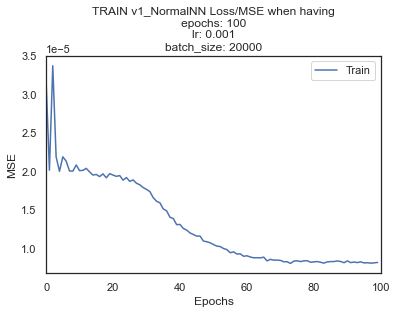

In [560]:
plt.plot(loss_values, linestyle='-', label='Train', color='C0');
plt.xlim(0, 100, 1);
plt.xlabel("Epochs");
plt.ylabel("MSE");
plt.title(f"TRAIN v1_NormalNN Loss/MSE when having\nepochs: {num_epochs}\nlr: {learning_rate}\nbatch_size: {batch_size}");
plt.legend();

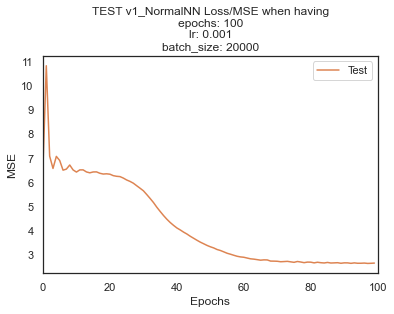

In [559]:
plt.plot(loss_values_test, linestyle='-', label='Test', color='C1');
plt.xlim(0, 100, 1);
plt.xlabel("Epochs");
plt.ylabel("MSE");
plt.title(f"TEST v1_NormalNN Loss/MSE when having\nepochs: {num_epochs}\nlr: {learning_rate}\nbatch_size: {batch_size}");
plt.legend();

In [557]:
print(f"""
TRAIN
    min  : {np.min(loss_values):2.8f}
    mean : {np.mean(loss_values):2.8f}
    max  : {np.max(loss_values):2.8f}
TEST
    min  : {np.min(loss_values_test):2.8f}
    mean : {np.mean(loss_values_test):2.8f}
    max  : {np.max(loss_values_test):2.8f}
""")


TRAIN
    min  : 0.00000809
    mean : 0.00001327
    max  : 0.00003377
TEST
    min  : 2.66170430
    mean : 4.24001741
    max  : 10.83005047



In [568]:
# Save model 
torch.save(model.state_dict(), PATH_TO_SAVE_MODELS_TO+'simpleNN.pkl')

In [572]:
torch.save(obj={
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_func': loss_func,
            'loss_values_train': loss_values,
            'loss_values_test': loss_values_test,
            },
            f=PATH_TO_SAVE_MODELS_TO+'simpleNN_extensive.pkl')

In [573]:
model_load = torch.load(PATH_TO_SAVE_MODELS_TO+'simpleNN_extensive.pkl')
model_load

{'epoch': 100,
 'model_state_dict': OrderedDict([('cell_branch.0.weight',
               tensor([[ 0.0254,  0.0275, -0.0078,  ...,  0.0115, -0.0314,  0.0030],
                       [-0.0082, -0.0246, -0.0318,  ...,  0.0231, -0.0057,  0.0260],
                       [-0.0058, -0.0181, -0.0198,  ...,  0.0294,  0.0285, -0.0156],
                       ...,
                       [-0.0120, -0.0154, -0.0158,  ...,  0.0054, -0.0155,  0.0159],
                       [-0.0287,  0.0330,  0.0186,  ...,  0.0319, -0.0094,  0.0122],
                       [-0.0364,  0.0239,  0.0016,  ..., -0.0126, -0.0059, -0.0121]])),
              ('cell_branch.0.bias',
               tensor([-6.4251e-03, -4.3917e-03,  7.8201e-03,  2.2410e-02,  1.9945e-02,
                       -1.7462e-02, -5.7303e-03, -3.2234e-03, -2.7765e-02, -1.6945e-02,
                        2.8574e-02,  1.9936e-02, -2.3944e-02,  1.5986e-03,  4.7320e-03,
                       -2.8071e-02,  2.3325e-02, -5.8056e-04, -8.6648e-03, -2.8837e-

In [569]:
# load model for testing purposes.
model_load = torch.load(PATH_TO_SAVE_MODELS_TO+'simpleNN.pkl')

In [571]:
model.state_dict

<bound method Module.state_dict of Model(
  (cell_branch): Sequential(
    (0): Linear(in_features=908, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (drug_branch): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
  )
  (fcn): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): ReLU()
  )
)>

In [570]:
model_load

OrderedDict([('cell_branch.0.weight',
              tensor([[ 0.0254,  0.0275, -0.0078,  ...,  0.0115, -0.0314,  0.0030],
                      [-0.0082, -0.0246, -0.0318,  ...,  0.0231, -0.0057,  0.0260],
                      [-0.0058, -0.0181, -0.0198,  ...,  0.0294,  0.0285, -0.0156],
                      ...,
                      [-0.0120, -0.0154, -0.0158,  ...,  0.0054, -0.0155,  0.0159],
                      [-0.0287,  0.0330,  0.0186,  ...,  0.0319, -0.0094,  0.0122],
                      [-0.0364,  0.0239,  0.0016,  ..., -0.0126, -0.0059, -0.0121]])),
             ('cell_branch.0.bias',
              tensor([-6.4251e-03, -4.3917e-03,  7.8201e-03,  2.2410e-02,  1.9945e-02,
                      -1.7462e-02, -5.7303e-03, -3.2234e-03, -2.7765e-02, -1.6945e-02,
                       2.8574e-02,  1.9936e-02, -2.3944e-02,  1.5986e-03,  4.7320e-03,
                      -2.8071e-02,  2.3325e-02, -5.8056e-04, -8.6648e-03, -2.8837e-02,
                       2.8342e-03, -1.4823e-

__CONCLUSION__: 
- The model is highly overfitted
  - While the train set has loss values of far below 1, the test set has values highly over 1

In [536]:
len(loss_values)

100

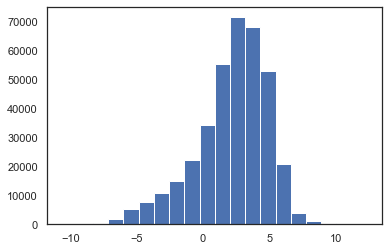

In [387]:
plt.hist(modeling_dataset.LN_IC50, bins=20);

---

## Model2 | Prevent Overfitting

- __Early Stopping__ doesn't make too much sense here (yet).
- __Dropout__ could prevent overfitting here and therefore be tried.
- 

In [ ]:
# ---------------- # 
# HYPER-PARAMETERS #
# ---------------- #
input_size   = 910 # which is gene_expr_base.shape[0]-1 = 911 - 1
                   # One value per feature
hidden_size   = 100
num_classes   = 1
num_epochs    = 100
batch_size    = 20_000
learning_rate = 0.001  

# ---------------------------- #
# CREATE TRAIN & TEST DATASETS #
# ---------------------------- #
train_loader = torch.utils.data.DataLoader(dataset     = train_set, 
                                           batch_size  = batch_size, 
                                           shuffle     = True,
                                           num_workers = 0)

test_loader = torch.utils.data.DataLoader(dataset     = test_set, 
                                          batch_size  = batch_size, 
                                          shuffle     = True,
                                          num_workers = 0) 

In [579]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model2
from my_utils.model_helpers import train_and_test_model


# ---------- #
# INITIALIZE #
# ---------- #
model2 = Model2().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model2, loss_values2, loss_values_test2 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model2,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.5953
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 11.6228
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 11.5949
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [4/100], Step [1/15], Loss: 11.4223
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 11.5735
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [6/100], Step [1/15], Loss: 11.5213
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [7/100], Step [1/15], Loss: 11.7625
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [8/100], Step [1/15], Loss: 11.5808
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 11.4807
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 11.4059
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 11.6090
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [12/100], Step [1/15], Loss: 11.5921
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [13/100], Step [1/15], Loss: 11.5124
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 11.6343
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 11.5332
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.166902542114258


0it [00:02, ?it/s]


Epoch [16/100], Step [1/15], Loss: 11.6050
loss_values : 0.0000


4it [00:09,  2.34s/it]


MSE (test) : 10.166902542114258


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 11.5985
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 11.4482
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.166900634765625


0it [00:04, ?it/s]


Epoch [19/100], Step [1/15], Loss: 11.6508
loss_values : 0.0000


4it [00:09,  2.25s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [20/100], Step [1/15], Loss: 11.5077
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 11.5813
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 10.166902542114258


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 11.5638
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [23/100], Step [1/15], Loss: 11.6083
loss_values : 0.0000


4it [00:07,  1.94s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [24/100], Step [1/15], Loss: 11.6083
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 11.6260
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [26/100], Step [1/15], Loss: 11.7809
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 11.5944
loss_values : 0.0000


4it [00:08,  2.04s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 11.7286
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [29/100], Step [1/15], Loss: 11.5975
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 11.6314
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 11.5899
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [32/100], Step [1/15], Loss: 11.7065
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 11.4146
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 11.5727
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.166899681091309


0it [00:03, ?it/s]


Epoch [35/100], Step [1/15], Loss: 11.4995
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [36/100], Step [1/15], Loss: 11.5138
loss_values : 0.0000


4it [00:10,  2.64s/it]


MSE (test) : 10.166899681091309


0it [00:03, ?it/s]


Epoch [37/100], Step [1/15], Loss: 11.5943
loss_values : 0.0000


4it [00:07,  1.91s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 11.5034
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [39/100], Step [1/15], Loss: 11.5158
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 11.5442
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 10.166899681091309


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 11.4385
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [42/100], Step [1/15], Loss: 11.5612
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [43/100], Step [1/15], Loss: 11.6539
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [44/100], Step [1/15], Loss: 11.4624
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 11.5661
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [46/100], Step [1/15], Loss: 11.5555
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 11.5081
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 11.6358
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [49/100], Step [1/15], Loss: 11.5915
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [50/100], Step [1/15], Loss: 11.5053
loss_values : 0.0000


4it [00:07,  1.92s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [51/100], Step [1/15], Loss: 11.6065
loss_values : 0.0000


4it [00:08,  2.10s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 11.5622
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [53/100], Step [1/15], Loss: 11.5420
loss_values : 0.0000


4it [00:07,  1.96s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 11.4827
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [55/100], Step [1/15], Loss: 11.6876
loss_values : 0.0000


4it [00:10,  2.54s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [56/100], Step [1/15], Loss: 11.5740
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.166900634765625


0it [00:06, ?it/s]

Epoch [57/100], Step [1/15], Loss: 11.3710


loss_values : 0.0000


4it [00:12,  3.01s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [58/100], Step [1/15], Loss: 11.5618
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [59/100], Step [1/15], Loss: 11.6234
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.166900634765625


0it [00:03, ?it/s]


Epoch [60/100], Step [1/15], Loss: 11.5174
loss_values : 0.0000


4it [00:07,  1.93s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [61/100], Step [1/15], Loss: 11.5902
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 11.5813
loss_values : 0.0000


4it [00:11,  2.75s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 11.6278
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.166899681091309


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 11.6508
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 11.6432
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 11.6784
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 11.6328
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 11.6561
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.166900634765625


0it [00:06, ?it/s]


Epoch [69/100], Step [1/15], Loss: 11.7567
loss_values : 0.0000


4it [00:07,  1.87s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 11.6405
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [71/100], Step [1/15], Loss: 11.6289
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 11.5650
loss_values : 0.0000


4it [00:07,  1.90s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 11.5924
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 10.166901588439941


0it [00:05, ?it/s]


Epoch [74/100], Step [1/15], Loss: 11.5020
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 11.5356
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 11.6511
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [77/100], Step [1/15], Loss: 11.5640
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 11.5623
loss_values : 0.0000


4it [00:06,  1.54s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 11.5473
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 11.5191
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 11.5766
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [82/100], Step [1/15], Loss: 11.4923
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 11.5767
loss_values : 0.0000


4it [00:07,  1.81s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 11.5268
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 11.5140
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [86/100], Step [1/15], Loss: 11.7286
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [87/100], Step [1/15], Loss: 11.4683
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [88/100], Step [1/15], Loss: 11.7625
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 11.5183
loss_values : 0.0000


4it [00:07,  1.88s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 11.4583
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [91/100], Step [1/15], Loss: 11.6002
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.166899681091309


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 11.6064
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 11.6438
loss_values : 0.0000


4it [00:08,  2.00s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 11.5397
loss_values : 0.0000


4it [00:07,  1.86s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 11.5128
loss_values : 0.0000


4it [00:07,  1.89s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [96/100], Step [1/15], Loss: 11.5767
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 10.166900634765625


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 11.5133
loss_values : 0.0000


4it [00:07,  1.84s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [98/100], Step [1/15], Loss: 11.5818
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.166901588439941


0it [00:03, ?it/s]


Epoch [99/100], Step [1/15], Loss: 11.5625
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.166901588439941


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 11.6291
loss_values : 0.0000


4it [00:07,  1.83s/it]


MSE (test) : 10.166901588439941



TRAIN
    min  : 0.00003065
    mean : 0.00003120
    max  : 0.00003176
TEST
    min  : 10.16689968
    mean : 10.16690159
    max  : 10.16690254



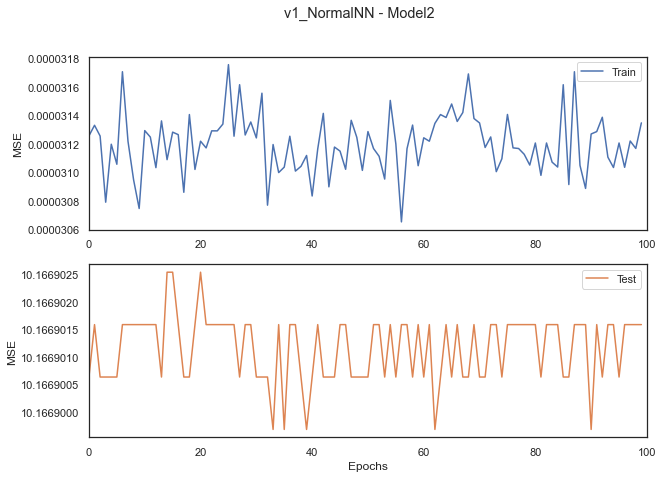

In [608]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 7)

fig, axs = plt.subplots(2)
fig.suptitle("v1_NormalNN - Model2");
# Train
axs[0].plot(loss_values2, linestyle='-', label='Train', color='C0');
axs[0].legend();
axs[0].ticklabel_format(style='plain');
axs[0].set_xlim(0, num_epochs, 1);
axs[0].set_ylabel("MSE");
# Test
axs[1].plot(loss_values_test2, linestyle='-', label='Test', color='C1');
axs[1].legend();
# axs[1].ticklabel_format(style='plain');
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
axs[1].set_xlim(0, num_epochs, 1);
axs[1].set_xlabel("Epochs");
axs[1].set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values2):2.8f}
    mean : {np.mean(loss_values2):2.8f}
    max  : {np.max(loss_values2):2.8f}
TEST
    min  : {np.min(loss_values_test2):2.8f}
    mean : {np.mean(loss_values_test2):2.8f}
    max  : {np.max(loss_values_test2):2.8f}
""")



---

## Model3 | Use [DeepCDR](http://liuqiao.me/files/DeepCDR.pdf)'s gene epxression network structure | Prevent Overfitting

- __Early Stopping__ doesn't make too much sense here (yet).
- __Dropout__ could prevent overfitting here and therefore be tried.
- 

In [613]:
%load_ext autoreload
%autoreload 24
from v1_NormalNN            import Model3
from my_utils.model_helpers import train_and_test_model


# ---------- #
# INITIALIZE #
# ---------- #
model3 = Model3().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# ---------------- #
# TRAIN & EVALUATE #
# ---------------- #
model3, loss_values3, loss_values_test3 = train_and_test_model(
    modeling_dataset = modeling_dataset,
    model            = model3,
    criterion        = loss_func,
    optimizer        = optimizer,
    num_epochs       = 100,
    device           = device,
    train_loader     = train_loader,
    test_loader      = test_loader
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


0it [00:02, ?it/s]


Epoch [1/100], Step [1/15], Loss: 11.7447
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 10.347090721130371


0it [00:02, ?it/s]


Epoch [2/100], Step [1/15], Loss: 11.6912
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 10.347039222717285


0it [00:02, ?it/s]


Epoch [3/100], Step [1/15], Loss: 11.9560
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.34700870513916


0it [00:02, ?it/s]


Epoch [4/100], Step [1/15], Loss: 11.7206
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 10.346997261047363


0it [00:02, ?it/s]


Epoch [5/100], Step [1/15], Loss: 11.7516
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.346997261047363


0it [00:02, ?it/s]


Epoch [6/100], Step [1/15], Loss: 11.8599
loss_values : 0.0000


4it [00:09,  2.40s/it]


MSE (test) : 10.34701156616211


0it [00:01, ?it/s]


Epoch [7/100], Step [1/15], Loss: 11.7261
loss_values : 0.0000


4it [00:06,  1.59s/it]


MSE (test) : 10.34703254699707


0it [00:01, ?it/s]


Epoch [8/100], Step [1/15], Loss: 11.7791
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347062110900879


0it [00:02, ?it/s]


Epoch [9/100], Step [1/15], Loss: 11.7418
loss_values : 0.0000


4it [00:06,  1.50s/it]


MSE (test) : 10.347094535827637


0it [00:02, ?it/s]


Epoch [10/100], Step [1/15], Loss: 11.7164
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 10.34713077545166


0it [00:02, ?it/s]


Epoch [11/100], Step [1/15], Loss: 11.8950
loss_values : 0.0000


4it [00:06,  1.51s/it]


MSE (test) : 10.34716796875


0it [00:01, ?it/s]


Epoch [12/100], Step [1/15], Loss: 11.7631
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.347208023071289


0it [00:02, ?it/s]


Epoch [13/100], Step [1/15], Loss: 11.8914
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.347245216369629


0it [00:02, ?it/s]


Epoch [14/100], Step [1/15], Loss: 11.6813
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347284317016602


0it [00:02, ?it/s]


Epoch [15/100], Step [1/15], Loss: 11.7822
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347320556640625


0it [00:02, ?it/s]


Epoch [16/100], Step [1/15], Loss: 11.8289
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 10.347355842590332


0it [00:02, ?it/s]


Epoch [17/100], Step [1/15], Loss: 11.7440
loss_values : 0.0000


4it [00:06,  1.55s/it]


MSE (test) : 10.347387313842773


0it [00:02, ?it/s]


Epoch [18/100], Step [1/15], Loss: 11.7280
loss_values : 0.0000


4it [00:06,  1.60s/it]


MSE (test) : 10.347418785095215


0it [00:02, ?it/s]


Epoch [19/100], Step [1/15], Loss: 11.7343
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.347448348999023


0it [00:02, ?it/s]


Epoch [20/100], Step [1/15], Loss: 11.7641
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.3474760055542


0it [00:02, ?it/s]


Epoch [21/100], Step [1/15], Loss: 11.8539
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 10.347500801086426


0it [00:02, ?it/s]


Epoch [22/100], Step [1/15], Loss: 11.6825
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 10.347524642944336


0it [00:02, ?it/s]


Epoch [23/100], Step [1/15], Loss: 11.8265
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.347545623779297


0it [00:02, ?it/s]


Epoch [24/100], Step [1/15], Loss: 11.8819
loss_values : 0.0000


4it [00:06,  1.61s/it]


MSE (test) : 10.347564697265625


0it [00:02, ?it/s]


Epoch [25/100], Step [1/15], Loss: 11.9767
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 10.347582817077637


0it [00:01, ?it/s]


Epoch [26/100], Step [1/15], Loss: 11.8113
loss_values : 0.0000


4it [00:06,  1.54s/it]


MSE (test) : 10.347599983215332


0it [00:02, ?it/s]


Epoch [27/100], Step [1/15], Loss: 11.8429
loss_values : 0.0000


4it [00:06,  1.57s/it]


MSE (test) : 10.347615242004395


0it [00:02, ?it/s]


Epoch [28/100], Step [1/15], Loss: 11.8102
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 10.347630500793457


0it [00:02, ?it/s]


Epoch [29/100], Step [1/15], Loss: 11.7422
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.347641944885254


0it [00:02, ?it/s]


Epoch [30/100], Step [1/15], Loss: 11.8041
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 10.347654342651367


0it [00:02, ?it/s]


Epoch [31/100], Step [1/15], Loss: 11.8353
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.347664833068848


0it [00:02, ?it/s]


Epoch [32/100], Step [1/15], Loss: 11.8619
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 10.347673416137695


0it [00:02, ?it/s]


Epoch [33/100], Step [1/15], Loss: 11.9390
loss_values : 0.0000


4it [00:06,  1.56s/it]


MSE (test) : 10.34768295288086


0it [00:02, ?it/s]


Epoch [34/100], Step [1/15], Loss: 11.7470
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.347689628601074


0it [00:02, ?it/s]


Epoch [35/100], Step [1/15], Loss: 11.8167
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 10.347697257995605


0it [00:02, ?it/s]


Epoch [36/100], Step [1/15], Loss: 11.8971
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.347702980041504


0it [00:02, ?it/s]


Epoch [37/100], Step [1/15], Loss: 11.7774
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.347710609436035


0it [00:02, ?it/s]


Epoch [38/100], Step [1/15], Loss: 11.6440
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 10.347716331481934


0it [00:01, ?it/s]


Epoch [39/100], Step [1/15], Loss: 11.8299
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.3477201461792


0it [00:02, ?it/s]


Epoch [40/100], Step [1/15], Loss: 11.8729
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.347724914550781


0it [00:02, ?it/s]


Epoch [41/100], Step [1/15], Loss: 11.7502
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.347729682922363


0it [00:02, ?it/s]


Epoch [42/100], Step [1/15], Loss: 11.8256
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 10.347731590270996


0it [00:02, ?it/s]


Epoch [43/100], Step [1/15], Loss: 11.7015
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.347733497619629


0it [00:02, ?it/s]


Epoch [44/100], Step [1/15], Loss: 11.8459
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.347737312316895


0it [00:02, ?it/s]


Epoch [45/100], Step [1/15], Loss: 11.9851
loss_values : 0.0000


4it [00:06,  1.73s/it]


MSE (test) : 10.347740173339844


0it [00:02, ?it/s]


Epoch [46/100], Step [1/15], Loss: 11.7424
loss_values : 0.0000


4it [00:08,  2.17s/it]


MSE (test) : 10.347744941711426


0it [00:02, ?it/s]


Epoch [47/100], Step [1/15], Loss: 11.9407
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.347744941711426


0it [00:02, ?it/s]


Epoch [48/100], Step [1/15], Loss: 11.8863
loss_values : 0.0000


4it [00:06,  1.75s/it]


MSE (test) : 10.347748756408691


0it [00:02, ?it/s]


Epoch [49/100], Step [1/15], Loss: 11.7424
loss_values : 0.0000


4it [00:07,  1.80s/it]


MSE (test) : 10.347750663757324


0it [00:02, ?it/s]


Epoch [50/100], Step [1/15], Loss: 11.9266
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347752571105957


0it [00:02, ?it/s]


Epoch [51/100], Step [1/15], Loss: 11.7040
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347753524780273


0it [00:02, ?it/s]


Epoch [52/100], Step [1/15], Loss: 11.8347
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 10.347753524780273


0it [00:02, ?it/s]


Epoch [53/100], Step [1/15], Loss: 11.7667
loss_values : 0.0000


4it [00:06,  1.53s/it]


MSE (test) : 10.34775447845459


0it [00:02, ?it/s]


Epoch [54/100], Step [1/15], Loss: 11.6865
loss_values : 0.0000


4it [00:06,  1.55s/it]


MSE (test) : 10.347756385803223


0it [00:02, ?it/s]


Epoch [55/100], Step [1/15], Loss: 11.8903
loss_values : 0.0000


4it [00:06,  1.57s/it]


MSE (test) : 10.347757339477539


0it [00:02, ?it/s]


Epoch [56/100], Step [1/15], Loss: 11.7256
loss_values : 0.0000


4it [00:06,  1.53s/it]


MSE (test) : 10.347757339477539


0it [00:02, ?it/s]


Epoch [57/100], Step [1/15], Loss: 11.8411
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347758293151855


0it [00:01, ?it/s]


Epoch [58/100], Step [1/15], Loss: 11.8148
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347759246826172


0it [00:01, ?it/s]


Epoch [59/100], Step [1/15], Loss: 11.7292
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 10.347760200500488


0it [00:02, ?it/s]


Epoch [60/100], Step [1/15], Loss: 11.8282
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 10.347760200500488


0it [00:02, ?it/s]


Epoch [61/100], Step [1/15], Loss: 11.7647
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347760200500488


0it [00:02, ?it/s]


Epoch [62/100], Step [1/15], Loss: 11.8152
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347759246826172


0it [00:02, ?it/s]


Epoch [63/100], Step [1/15], Loss: 11.7988
loss_values : 0.0000


4it [00:06,  1.74s/it]


MSE (test) : 10.347759246826172


0it [00:02, ?it/s]


Epoch [64/100], Step [1/15], Loss: 11.8292
loss_values : 0.0000


4it [00:06,  1.63s/it]


MSE (test) : 10.347761154174805


0it [00:02, ?it/s]


Epoch [65/100], Step [1/15], Loss: 11.5773
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.347759246826172


0it [00:02, ?it/s]


Epoch [66/100], Step [1/15], Loss: 11.6635
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347761154174805


0it [00:02, ?it/s]


Epoch [67/100], Step [1/15], Loss: 11.8144
loss_values : 0.0000


4it [00:06,  1.57s/it]


MSE (test) : 10.347760200500488


0it [00:02, ?it/s]


Epoch [68/100], Step [1/15], Loss: 11.8214
loss_values : 0.0000


4it [00:06,  1.55s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [69/100], Step [1/15], Loss: 11.8989
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [70/100], Step [1/15], Loss: 11.8988
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 10.347762107849121


0it [00:01, ?it/s]


Epoch [71/100], Step [1/15], Loss: 11.7131
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [72/100], Step [1/15], Loss: 11.6250
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [73/100], Step [1/15], Loss: 11.7810
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 10.347761154174805


0it [00:01, ?it/s]


Epoch [74/100], Step [1/15], Loss: 11.8394
loss_values : 0.0000


4it [00:07,  1.76s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [75/100], Step [1/15], Loss: 11.7514
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [76/100], Step [1/15], Loss: 11.7793
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 10.347763061523438


0it [00:02, ?it/s]


Epoch [77/100], Step [1/15], Loss: 11.8195
loss_values : 0.0000


4it [00:06,  1.55s/it]


MSE (test) : 10.347763061523438


0it [00:02, ?it/s]


Epoch [78/100], Step [1/15], Loss: 11.9549
loss_values : 0.0000


4it [00:07,  1.78s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [79/100], Step [1/15], Loss: 11.9071
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.347763061523438


0it [00:02, ?it/s]


Epoch [80/100], Step [1/15], Loss: 11.8264
loss_values : 0.0000


4it [00:06,  1.58s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [81/100], Step [1/15], Loss: 11.7221
loss_values : 0.0000


4it [00:06,  1.64s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [82/100], Step [1/15], Loss: 11.7978
loss_values : 0.0000


4it [00:06,  1.65s/it]


MSE (test) : 10.347762107849121


0it [00:02, ?it/s]


Epoch [83/100], Step [1/15], Loss: 11.6780
loss_values : 0.0000


4it [00:06,  1.70s/it]


MSE (test) : 10.347763061523438


0it [00:02, ?it/s]


Epoch [84/100], Step [1/15], Loss: 11.8544
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347763061523438


0it [00:02, ?it/s]


Epoch [85/100], Step [1/15], Loss: 11.6179
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347764015197754


0it [00:02, ?it/s]


Epoch [86/100], Step [1/15], Loss: 11.6611
loss_values : 0.0000


4it [00:06,  1.53s/it]


MSE (test) : 10.347764015197754


0it [00:02, ?it/s]


Epoch [87/100], Step [1/15], Loss: 11.8655
loss_values : 0.0000


4it [00:06,  1.62s/it]


MSE (test) : 10.347764015197754


0it [00:01, ?it/s]


Epoch [88/100], Step [1/15], Loss: 11.7708
loss_values : 0.0000


4it [00:06,  1.67s/it]


MSE (test) : 10.347764015197754


0it [00:02, ?it/s]


Epoch [89/100], Step [1/15], Loss: 11.8507
loss_values : 0.0000


4it [00:06,  1.66s/it]


MSE (test) : 10.34776496887207


0it [00:02, ?it/s]


Epoch [90/100], Step [1/15], Loss: 11.7157
loss_values : 0.0000


4it [00:07,  1.79s/it]


MSE (test) : 10.34776496887207


0it [00:02, ?it/s]


Epoch [91/100], Step [1/15], Loss: 11.8316
loss_values : 0.0000


4it [00:06,  1.72s/it]


MSE (test) : 10.347765922546387


0it [00:02, ?it/s]


Epoch [92/100], Step [1/15], Loss: 11.7888
loss_values : 0.0000


4it [00:07,  1.75s/it]


MSE (test) : 10.347765922546387


0it [00:02, ?it/s]


Epoch [93/100], Step [1/15], Loss: 11.8017
loss_values : 0.0000


4it [00:06,  1.69s/it]


MSE (test) : 10.347765922546387


0it [00:02, ?it/s]


Epoch [94/100], Step [1/15], Loss: 11.7852
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.34776496887207


0it [00:02, ?it/s]


Epoch [95/100], Step [1/15], Loss: 11.9008
loss_values : 0.0000


4it [00:06,  1.71s/it]


MSE (test) : 10.34776496887207


0it [00:01, ?it/s]


Epoch [96/100], Step [1/15], Loss: 11.7071
loss_values : 0.0000


4it [00:05,  1.39s/it]


MSE (test) : 10.347766876220703


0it [00:02, ?it/s]


Epoch [97/100], Step [1/15], Loss: 11.8362
loss_values : 0.0000


4it [00:07,  1.85s/it]


MSE (test) : 10.34776496887207


0it [00:02, ?it/s]


Epoch [98/100], Step [1/15], Loss: 11.6104
loss_values : 0.0000


4it [00:06,  1.68s/it]


MSE (test) : 10.347765922546387


0it [00:02, ?it/s]


Epoch [99/100], Step [1/15], Loss: 11.7231
loss_values : 0.0000


4it [00:07,  1.82s/it]


MSE (test) : 10.347765922546387


0it [00:02, ?it/s]


Epoch [100/100], Step [1/15], Loss: 11.7291
loss_values : 0.0000


4it [00:07,  1.77s/it]


MSE (test) : 10.347766876220703



TRAIN
    min  : 0.00003065
    mean : 0.00003120
    max  : 0.00003176
TEST
    min  : 10.16689968
    mean : 10.16690159
    max  : 10.16690254



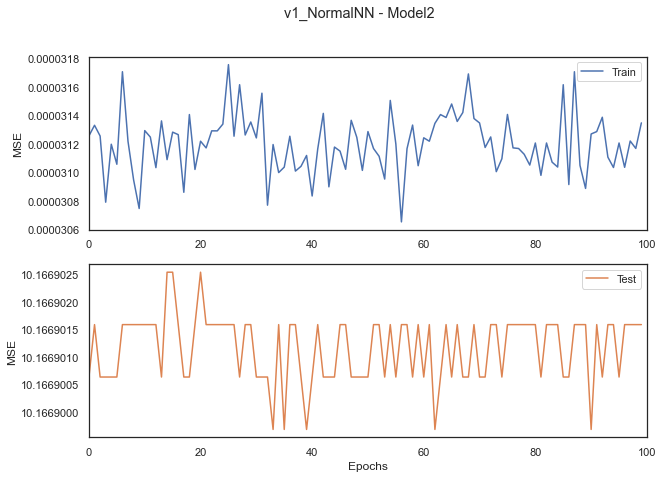

In [614]:
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["figure.figsize"] = (10, 7)

fig, axs = plt.subplots(2)
fig.suptitle("v1_NormalNN - Model3");
# Train
axs[0].plot(loss_values3, linestyle='-', label='Train', color='C0');
axs[0].legend();
axs[0].ticklabel_format(style='plain');
axs[0].set_xlim(0, num_epochs, 1);
axs[0].set_ylabel("MSE");
# Test
axs[1].plot(loss_values_test3, linestyle='-', label='Test', color='C1');
axs[1].legend();
# axs[1].ticklabel_format(style='plain');
axs[1].yaxis.set_major_formatter(FormatStrFormatter('%.7f'))
axs[1].set_xlim(0, num_epochs, 1);
axs[1].set_xlabel("Epochs");
axs[1].set_ylabel("MSE");

print(f"""
TRAIN
    min  : {np.min(loss_values3):2.8f}
    mean : {np.mean(loss_values3):2.8f}
    max  : {np.max(loss_values3):2.8f}
TEST
    min  : {np.min(loss_values_test3):2.8f}
    mean : {np.mean(loss_values_test3):2.8f}
    max  : {np.max(loss_values_test3):2.8f}
""")



In [202]:
gene_expr_data

tensor([[7.4722, 5.8678, 4.9159,  ..., 6.6141, 8.5520, 3.2697],
        [7.4081, 6.1157, 6.0675,  ..., 3.6499, 6.8504, 3.5596],
        [7.2114, 7.4453, 5.6951,  ..., 3.6498, 8.3988, 3.8715],
        ...,
        [7.0449, 6.8248, 4.8239,  ..., 4.6832, 9.6526, 3.7312],
        [7.1434, 6.8708, 6.0484,  ..., 7.9259, 8.3798, 3.4813],
        [7.5782, 7.3208, 5.1952,  ..., 7.5937, 7.9628, 3.4822]],
       dtype=torch.float64)

In [132]:
np1 = np.array([[1], 
                [2]])
np2 = np.array([[3], 
                [4]])
np3 = np.array([[5], 
                [6]])

"""
1.dim = features
2.dim = cell-lines
3.dim = genes
"""

t = torch.tensor([np1, np2, np3])
print(t.shape)
t

torch.Size([3, 2, 1])


tensor([[[1],
         [2]],

        [[3],
         [4]],

        [[5],
         [6]]])

In [138]:
t2 = torch.flatten(t, start_dim=1)
t2

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [154]:
np.reshape(t, (2, 3), order='F')

tensor([[1, 5, 4],
        [3, 2, 6]])

In [156]:
np.ravel(t, order='F').reshape((2, t.shape[0] * t.shape[2]))

array([[1, 3, 5],
       [2, 4, 6]])

---

## Drug Features

In [27]:
with open(f'{PATH_TO_SAVED_DRUG_FEATURES}drug_name_fingerprints_dataframe.pkl', 'rb') as f:
    drug_name_fps = pickle.load(f)
print(f"Shape: {drug_name_fps.shape}")
drug_name_fps.head(3)   

Shape: (367, 257)


,drug_name,0,1,2,3,4,5,6,7,8,...,246,247,248,249,250,251,252,253,254,255
0,(5Z)-7-Oxozeaenol,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
1,5-Fluorouracil,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,A-443654,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


The encoded drug feature dataset has 367 unique drug names and per drug name a 256 sized De-Morgan fingerprint.